# YOLOv8用于检测牌的位置，而LSTM则学习这些位置的时间序列模式，从而预测未来的行为。
- You Only Look Once YOLO 接受整张图片作为输入划分为网格，每个网格预测一组边界框和对应的物体类别，这让 YOLO 很快
- YOLO 将物体检测视为回归问题来解决，直接从图片生成边界框坐标和类别概率
- LSTM Long Short-Term Memory 长短期记忆网络，适合时间序列预测的行为模式

**这是一个相对复杂的深度学习应用，适用于人和动物行为研究中需要分析大量序列数据的场景。**

## 数据预处理
样本数num_samples: 54 poker, 每个样本time_steps: 20个时间序列, 每个时间序列num_features: 10个特征(待加入更多)

In [1]:
%pip install tensorflow==2.15 filterpy opencv-python pillow numpy scikit-learn tensorboard pandas tf2onnx onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 50.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 81.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 83.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 81.6 MB/s eta 0:00:00:00:0100:01

In [2]:
# import tensorflow.keras
# print(tensorflow.keras.__version__)

# import os
# os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
# Install the ultralytics package from GitHub
%pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-rdczv59r
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-rdczv59r
  Resolved https://github.com/ultralytics/ultralytics.git to commit f03f0fde2efb433e1ab8f6a5c7e1c477d027bbc8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 997.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.4 MB/s eta 0:00:00
  Created wheel for ultralytics: filename=ultralytics-8.2.90-py3-none-any.whl size=871756 sha256=915619601ebb9c296f9effd64a807d3f6aee99503b5059e7b8767dae06a1440e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehimg88x/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f84

In [11]:
from ultralytics import YOLO
import torch
import platform

# 加载YOLOv8 模型
def load_yolo_model():
    os_type = platform.system()

    if os_type == 'Linux':
        # 在 Linux 上加载模型
        yolo_model = YOLO('poker/n_pretrain/weights/best.pt')
    elif os_type == 'Darwin':  # Darwin 是 macOS 的系统名称
        # 在 macOS 上加载模型
        yolo_model = YOLO("poker/n_pretrain/weights/pokerDetect_0821-fp-16-int8-not-nms.mlmodel")
    else:
        raise OSError(f"Unsupported operating system: {os_type}")
    
    return yolo_model

# 调用函数并获取 yolo_model 对象
yolo_model = load_yolo_model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


## 1. YOLOv8 模型检测

In [ ]:

from ultralytics import YOLO
import torch
import cv2
import numpy as np

#from sort import Sort
#https://github.com/RizwanMunawar/yolov7-object-tracking/blob/main/sort.py

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer, Masking, BatchNormalization, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import os

from concurrent.futures import ThreadPoolExecutor, as_completed


# 1. 多目标的位置
def detect_objects(frame):
    results = yolo_model(frame)  # 进行目标检测
    detections = {
        'Tc': [], 'Td': [], 'Th': [], 'Ts': [],
        '2c': [], '2d': [], '2h': [], '2s': [],
        '3c': [], '3d': [], '3h': [], '3s': [],
        '4c': [], '4d': [], '4h': [], '4s': [],
        '5c': [], '5d': [], '5h': [], '5s': [],
        '6c': [], '6d': [], '6h': [], '6s': [],
        '7c': [], '7d': [], '7h': [], '7s': [],
        '8c': [], '8d': [], '8h': [], '8s': [],
        '9c': [], '9d': [], '9h': [], '9s': [],
        'Ac': [], 'Ad': [], 'Ah': [], 'As': [],
        'Jc': [], 'Jd': [], 'Jh': [], 'Js': [],
        'Kc': [], 'Kd': [], 'Kh': [], 'Ks': [],
        'Qc': [], 'Qd': [], 'Qh': [], 'Qs': [],
        'SJoker': [], 'BJoker': []
    }
    for result in results:
        for obj in result.boxes: # 提取检测结果
            if obj.conf.item() > 0.5:
                # tensor to numpy
                #bbox = obj.xyxy[0].cpu().numpy()
                #x_min, y_min, x_max, y_max = obj.xyxy[0]
                bbox = obj.xyxy[0].cpu().numpy().astype(int)
                x_min, y_min, x_max, y_max = bbox
                
                # roi = frame[y_min:y_max, x_min:x_max]
                # roi_resized = cv2.resize(roi, (64, 64))
                
                # 数据增强: 随机翻转和旋转
                # if np.random.rand() > 0.5:
                #     roi_resized = cv2.flip(roi_resized, 1)
                # angle = np.random.uniform(-10, 10)
                # M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)
                # roi_resized = cv2.warpAffine(roi_resized, M, (64, 64))
                # roi_tensor = torch.tensor(roi_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
                #张量的形状变为 (1, 通道, 高度, 宽度)
                #print("ROI Tensor:", roi_tensor)
                
                #x_center = (x_min + x_max) / 2
                #y_center = (y_min + y_max) / 2
                # Get the boxes center coordinates (x, y), width (w), and height (h) size
                x, y, w, h = obj.xywh[0].cpu()
                speed = np.sqrt((w ** 2 + h ** 2))
                conf = obj.conf.item()
                # labels names
                class_id = int(obj.cls.item())
                class_name = yolo_model.names[class_id]
                if class_name in detections:
                    detections[class_name].append([x_min, y_min, x_max, y_max, conf])

    return detections

# 2. 多模态输入包括上面的视频数据和其他传感器数据
#TODO: 假设我们有来自不同传感器的数据，Raspberry Pi 控制挂件装置，读取和处理传感器数据
sensor_data = np.random.rand(1000, 5)  # 例如溫度、光強度等

# 3. 同步处理多模态数据
def synchronize_data(detections, sensor_data):
    # hstack 将目标的检测数据与传感器数据在特征层面上拼接在一起，形成一个多模态输入矩阵
    return np.hstack([detections, sensor_data[:len(detections), :]])

# 获取同步后的数据
#sync_data = synchronize_data(all_detections, sensor_data)


## 1.1 卡尔曼滤波器精确追踪进行位置更新和噪声过滤

https://medium.com/@mosesdaudu001/object-detection-tracking-with-yolov8-and-sort-algorithm-363be8bc0806


Predicting future positions of moving objects is indeed a complex task that typically involves motion prediction algorithms such as Kalman filters 
or more advanced techniques like deep learning-based trajectory prediction.
预测移动物体的未来位置确实是一项复杂的任务，通常涉及运动预测算法（例如卡尔曼滤波器）或更先进的技术（例如基于深度学习的轨迹预测）。

YOLO's tracking algorithm already incorporates Kalman filtering
YOLO 的跟踪算法已经包含卡尔曼滤波器， 提取每个跟踪对象的当前状态（位置和速度），然后多次使用卡尔曼滤波器来预测其未来状态

In [9]:
from filterpy.kalman import KalmanFilter
# DeepSORT

def initialize_kalman_filter():
    kf = KalmanFilter(dim_x=7, dim_z=4)  # 7 个状态变量，4 个观测变量
    kf.F = np.array([[1,0,0,0,1,0,0],
                     [0,1,0,0,0,1,0],
                     [0,0,1,0,0,0,1],
                     [0,0,0,1,0,0,0],
                     [0,0,0,0,1,0,0],
                     [0,0,0,0,0,1,0],
                     [0,0,0,0,0,0,1]])  # 状态转移矩阵
    kf.H = np.array([[1,0,0,0,0,0,0],
                     [0,1,0,0,0,0,0],
                     [0,0,1,0,0,0,0],
                     [0,0,0,1,0,0,0]])  # 观测矩阵
    return kf

# 初始化卡尔曼滤波器
kf = initialize_kalman_filter()

def track_objects(detection):
    z = np.array([detection[0], detection[1], detection[2], detection[3]])  # 观测变量
    kf.predict()  # 预测下一步
    kf.update(z)  # 更新滤波
    return kf.x[:4]  # 返回更新后的位置信息
"""
# 追踪所有目标对象
tracked_positions = []
for det_list in all_detections.values():
    tracked_position = [track_objects(d) for d in det_list]
    tracked_positions.append(tracked_position)
    
tracked_positions
"""

'\n# 追踪所有目标对象\ntracked_positions = []\nfor det_list in all_detections.values():\n    tracked_position = [track_objects(d) for d in det_list]\n    tracked_positions.append(tracked_position)\n    \ntracked_positions\n'

## 2. 将视频帧或图像序列转换为LSTM模型的输入格式
** 每一个时间点的数据都包括前n个时间步长的数据**

In [8]:
import numpy as np

# 计算欧几里得距离
def calculate_distance(box1, box2):
    x1_center = (box1[0] + box1[2]) / 2
    y1_center = (box1[1] + box1[3]) / 2
    x2_center = (box2[0] + box2[2]) / 2
    y2_center = (box2[1] + box2[3]) / 2
    return np.sqrt((x1_center - x2_center)**2 + (y1_center - y2_center)**2)

# 计算检测框的面积
def calculate_area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

# 计算两个检测框之间的速度和角度
def calculate_velocity_and_angle(previous_box, current_box, time_interval):
    # 计算中心点
    previous_center = [(previous_box[0] + previous_box[2]) / 2, (previous_box[1] + previous_box[3]) / 2]
    current_center = [(current_box[0] + current_box[2]) / 2, (current_box[1] + current_box[3]) / 2]
    
    # 计算距离
    distance = np.sqrt((current_center[0] - previous_center[0])**2 + (current_center[1] - previous_center[1])**2)
    
    # 计算速度
    velocity = distance / time_interval
    
    # 计算角度(弧度), 表示检测框的运动方向
    direction = np.arctan2(current_center[1] - previous_center[1], current_center[0] - previous_center[0])
    
    return velocity, direction

                        
def prepare_complex_sequence_data(detected_objects_list, window_size=5, time_interval=1.0):
    X, y = [], []
    
    # TODO: 目前是追踪54个样本的轨迹, 计算同一帧的两个目标的关联关系?
    for key in detected_objects_list:
        card_detections = detected_objects_list[key]
        print(f"Key: {key}, vector len: {len(card_detections)}, Card Detections: {card_detections}")
        for i in range(len(card_detections) - window_size):
            input_seq = []
            for j in range(window_size):
                card_boxes = card_detections[i + j] 
                # 距離、面積、速度和置信度特徵
                if card_boxes:
                    cx = (card_boxes[0] + card_boxes[2]) / 2
                    cy = (card_boxes[1] + card_boxes[3]) / 2
                
                    card_area = calculate_area(card_boxes)
                    card_conf = card_boxes[4]  # 假设置信度在检测框的第五个元素
                    
                    if i > 0:  # 速度計算需要前一個時間點的數據
                        prev_card_box = card_detections[i + j - 1]
                        card_velocity, direction = calculate_velocity_and_angle(prev_card_box, card_boxes, time_interval)
                    else:
                        card_velocity = 0
                        direction = 0
                    
                    # 特征序列
                    input_seq.append([cx, cy])
                else:
                    input_seq.append([0, 0])
            
            # X 作为LSTM 的输入向量
            #seq = np.array(input_seq).flatten()
            X.append(input_seq)
            # y 作为LSTM 目标值, 构建 y 的 7 个特征, 下一frame的真实位置作为训练时的目标值
            next_card_boxes = card_detections[i + window_size]
            if next_card_boxes:
                next_card_area = calculate_area(next_card_boxes)
                cx = (next_card_boxes[0] + next_card_boxes[2]) / 2
                cy = (next_card_boxes[1] + next_card_boxes[3]) / 2
                next_card_conf = next_card_boxes[4]
                if i + window_size > 0:
                    prev_next_card_box = card_detections[i + window_size - 1]
                    next_card_velocity, direction = calculate_velocity_and_angle(prev_next_card_box, next_card_boxes, time_interval)
                else:
                    next_card_velocity = 0
                    direction = 0
                y.append([cx, cy])
            else:
                y.append([0, 0])

    return np.array(X), np.array(y)

In [7]:
def process_frame(frame, frame_index):
    res = detect_objects(frame)
    height, width = frame.shape[:2]
    if width == 0 or height == 0:
        return frame_index, {}  # 返回空结果，避免除以零

    return frame_index, res

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    all_detections = {
        'Tc': [], 'Td': [], 'Th': [], 'Ts': [],
        '2c': [], '2d': [], '2h': [], '2s': [],
        '3c': [], '3d': [], '3h': [], '3s': [],
        '4c': [], '4d': [], '4h': [], '4s': [],
        '5c': [], '5d': [], '5h': [], '5s': [],
        '6c': [], '6d': [], '6h': [], '6s': [],
        '7c': [], '7d': [], '7h': [], '7s': [],
        '8c': [], '8d': [], '8h': [], '8s': [],
        '9c': [], '9d': [], '9h': [], '9s': [],
        'Ac': [], 'Ad': [], 'Ah': [], 'As': [],
        'Jc': [], 'Jd': [], 'Jh': [], 'Js': [],
        'Kc': [], 'Kd': [], 'Kh': [], 'Ks': [],
        'Qc': [], 'Qd': [], 'Qh': [], 'Qs': [],
        'SJoker': [], 'BJoker': []
    }
    frames = []
    frame_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append((frame_index, frame))
        frame_index += 1

    cap.release()

    results = [None] * len(frames)  # 用于存储结果的列表，保持顺序

    with ThreadPoolExecutor(max_workers=1) as executor:
        future_to_frame = {executor.submit(process_frame, frame, idx): idx for idx, frame in frames}
        for future in as_completed(future_to_frame):
            idx, res = future.result()
            results[idx] = res  # 按照索引存储结果

    #FIXME: 合并结果前过滤掉异常值的结果
    for idx, res in enumerate(results):
        #logging.info(f'#: {idx}, result: {res}')
        for key in res.keys():
            all_detections[key].extend(res[key])
    return all_detections

## 3. 使用 Keras库來构建LSTM 模型与训练

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l1_l2

# Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)  # Energy
        a = tf.nn.softmax(e, axis=1)  # Attention weights
        output = tf.reduce_sum(x * a, axis=1)  # Weighted sum of input features
        return output

# 构建一个更复杂的双向LSTM模型，同时引入注意力机制, 使用检测到的数据进行训练。模型包括多层LSTM、Dropout、BatchNormalization等层
# input_shape=(time_steps, num_features)
def create_bilstm_attention_model(input_shape, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=0.0)(inputs)  # Add a Masking layer
    lstm_out = Bidirectional(LSTM(256, return_sequences=True))(masked_inputs)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
    # 添加 Dropout 和 BatchNormalization 层
    lstm_out = Dropout(dropout_rate)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    
    # 添加 GRU 层，units=64
    gru_out = GRU(units=64, return_sequences=True)(lstm_out)
    gru_out = Dropout(dropout_rate)(gru_out)
    gru_out = BatchNormalization()(gru_out)

    # Correct usage of Attention layer
    attention = Attention()(gru_out)

    # 全连接层，将 LSTM 的输出映射到32个神经元，并应用 ReLU 激活函数来引入非线性
    dense_out = Dense(32, activation='relu')(attention)
    
    feature_len = input_shape[1]
    # RepeatVector 和 TimeDistributed 层
    # "one-to-many" 的序列预测。RepeatVector 层将输入重复 5 次，TimeDistributed 层将 Dense 层的计算分布到每个时间步上。
    # 最终输出的形状将是 (batch_size, 5, feature_len)
    #repeat_out = RepeatVector(5)(dense_out)
    #outputs = TimeDistributed(Dense(units=feature_len, activation='relu'))(repeat_out)
    
    outputs = Dense(feature_len)(dense_out)  # The final Dense layer outputs 2 values 最后的全连接层，输出2个值
    
    model = Model(inputs, outputs)
    
    # 使用Adam优化器(梯度下降优化)和均方误差（MSE）作为损失函数，衡量预测值与实际值之间差异的指标，值越小，表示模型的预测效果越好
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])

    # 显示模型摘要
    model.summary()
    return model


## Eval 评估函数

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    # 均方根误差（RMSE）是一种用于衡量预测值与实际值之间差异的指标，值越小，表示模型的预测效果越好。 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # 平均绝对误差（MAE）
    mae = mean_absolute_error(y_test, y_pred)
    # R^2 分数
    r2 = r2_score(y_test, y_pred)
    
    return rmse, mse, mae, r2

def evaluate_inverse_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # 反归一化预测结果和真实值
    y_pred_inverse = scaler_y.inverse_transform(y_pred)
    y_test_inverse = scaler_y.inverse_transform(y_test)
    
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    # 均方根误差（RMSE）是一种用于衡量预测值与实际值之间差异的指标，值越小，表示模型的预测效果越好。 
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    # 平均绝对误差（MAE）
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    # R^2 分数
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    
    return rmse, mse, mae, r2

In [11]:
# coremltools 7 以上版本不需要安装 onnx-coreml
%pip install coremltools==7.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install -U coremltools


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 4. 将数据集拆分为训练集和测试集，训练LSTM模型并选择最佳模型

In [12]:
video_folder = 'videos/train'

In [16]:
video_folder = 'videos/debug/quick'

In [21]:
import tensorflow as tf
import coremltools as ct
import onnx
import tf2onnx
import joblib

import datetime
import os

import json

import logging

# 配置日志记录器
logging.basicConfig(
    level=logging.INFO,  # 设置日志级别为 INFO
    format='%(asctime)s - %(levelname)s - %(message)s',  # 设置日志格式
    handlers=[
        logging.StreamHandler(),  # 输出到控制台
        logging.FileHandler('app.log')  # 输出到文件
    ]
)

# 获取当前日期和时间
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# 获取 videos 文件夹中的所有视频文件路径
video_extensions = ['.mov', '.mp4', '.avi', '.mkv', '.flv', '.wmv']  # 支持的所有视频格式（小写）
video_paths = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if os.path.splitext(f)[1].lower() in video_extensions]

print("视频文件路径列表:", video_paths)

all_detected_objects_list = []
for video_path in video_paths:
    detected_objects_list = load_video_frames(video_path)
    all_detected_objects_list.append(detected_objects_list)

# 时序数据的一般格式 time、x 和 y 列
# 使用检测到的数据来训练,  X 是输入序列，y 是对应的目标输出
# 定义不同的时间步长度, 每次用前3个时间步的数据来预测下一个时间步的行为
time_steps = 5 # window_size 窗口大小
feature_len = 2  # 每个时间步的2 values，输出2个值，对应类目标的未来位置cx, cy, card_velocity, direction, card_conf)
#predict_times = 1  # 预测的时间步数
dropout_rate = 0.2  # dropout比例

# 记录变量信息
logging.info(f"time_steps: {time_steps}")
logging.info(f"feature_len: {feature_len}")
# logging.info(f"predict_times: {predict_times}")
logging.info(f"dropout_rate: {dropout_rate}")


X_all, y_all = [], []
for detected_objects_list in all_detected_objects_list:
    X, y = prepare_complex_sequence_data(detected_objects_list, time_steps)
    X_all.append(X)
    y_all.append(y)

# 填充序列，使所有样本具有相同的时间步长
X_all = pad_sequences(X_all, maxlen=time_steps, dtype='float32', padding='post', truncating='post')
y_all = pad_sequences(y_all, maxlen=time_steps, dtype='float32', padding='post', truncating='post')

# 合并所有视频样本的数据
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# 归一化处理特征数据
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_all = scaler_X.fit_transform(X_all.reshape(-1, X_all.shape[-1])).reshape(X_all.shape)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_all = scaler_y.fit_transform(y_all)

# 提取缩放器参数
scaler_X_params = {'min': scaler_X.data_min_.tolist(), 'max': scaler_X.data_max_.tolist()}
scaler_y_params = {'min': scaler_y.data_min_.tolist(), 'max': scaler_y.data_max_.tolist()}


print("X shape:", X_all.shape)  # 输出 (num_samples 54, window_size 5, feature_len 5)
print("y shape:", y_all.shape)  # 输出 (num_samples, feature_len)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print(f"X_test : {X_test}, y_test: {y_test}")

# 检查 X_train 的形状
print(f"X_train shape: {X_train.shape}, num_samples: {X_train.shape[0]}, window_size: {X_train.shape[1]}, feature_len: {X_train.shape[2]}")

# 确保目标数据的形状与模型的输出形状一致
# 目标数据的形状应该是 (batch_size, x, feature_len)
print(f"y_train shape: {y_train.shape}")
#y_train = np.reshape(y_train, (y_train.shape[0], predict_times, feature_len))
#print(f"y_train shape: {y_train.shape}, num_samples: {y_train.shape[0]}, window_size: {y_train.shape[1]}, feature_len: {y_train.shape[2]}")

# 校验数据集
calibration_data = X_train[:int(len(X_train) * 0.1)]  # 取前10%的样本
# 保存为NPZ文件
np.savez('model_lstm_calibration_data.npz', data=calibration_data)

# 模型训练
# LSTM模型的輸入形狀: X_train.shape[1] 是window_size，X_train.shape[2] num_features是指定目标的7个特征值(x1, y1, x2, y2, card_area, card_velocity, card_conf)
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_bilstm_attention_model(input_shape, dropout_rate)

# 定义回调函数
# Add Tensorboard
tb_callback = TensorBoard(log_dir='./tb_results', histogram_freq=0, write_graph=True, write_images=True)

# EarlyStopping：监控val_loss，如果50个epoch内没有改善，则停止训练，并恢复至最佳模型权重。
# ReduceLROnPlateau：当val_loss停止改善时，将学习率降低一半。
# ModelCheckpoint：在每个epoch后保存最佳模型
#early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
model_checkpoint = ModelCheckpoint(
    filepath=f'models/best_lstm_yolo_model_{current_time}.tensorflow.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
#model_checkpoint = ModelCheckpoint(f'best_lstm_yolo_model_{current_time}.tensorflow.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# 拟合nn训练模型: 整个数据集上训练12000次，每次训练32个样本，validation_data 在每个 epoch结束后计算验证集的损失
history = lstm_model.fit(X_train, y_train, 
                epochs=100,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[tb_callback, reduce_lr, model_checkpoint])

# # 保存 scaler
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# 保存为 JSON 文件
with open('scaler_X.json', 'w') as f:
    json.dump(scaler_X_params, f)

with open('scaler_y.json', 'w') as f:
    json.dump(scaler_y_params, f)

# 评估模型
train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"训练损失: {train_loss:.4f}, 训练Accuracy: {train_accuracy * 100:.2f}%, 测试损失: {test_loss:.4f}, 测试Accuracy: {test_accuracy * 100:.2f}%")
logging.info(f"训练损失: {train_loss:.4f}, 训练Accuracy: {train_accuracy * 100:.2f}%, 测试损失: {test_loss:.4f}, 测试Accuracy: {test_accuracy * 100:.2f}%")
# 选择最佳模型
# 训练过程中每个 epoch 的验证损失值
val_loss = history.history['val_loss']
# 验证损失最小的 epoch 对应就是最佳模型, 保存为lstm_weights_xx.h5文件
best_epoch = np.argmin(val_loss)
best_model = load_model(f'best_lstm_yolo_model_{current_time}.tensorflow.keras', custom_objects={'Attention': Attention})
best_model.save(f'best_lstm_yolo_model_{current_time}.h5')  # 保存整个模型

# 将 Keras 模型转换为 ONNX 格式
spec = (tf.TensorSpec((None, X_train.shape[1], X_train.shape[2]), tf.float32, name="input"),)
output_path = f'best_lstm_yolo_model_{current_time}.onnx'
model_proto, _ = tf2onnx.convert.from_keras(best_model, input_signature=spec, opset=13)
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())
print(f"模型成功保存为 ONNX 格式，路径为: {output_path}")

# Convert the model to tflite.
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open(f'best_lstm_yolo_model_{current_time}.tflite', 'wb') as f:
  f.write(tflite_model)

## 转换Core ML 模型
# 定义输入
sequence_input = ct.TensorType(shape=(1, X_train.shape[1], X_train.shape[2]))

# 进行模型转换
coreml_model = ct.convert(
    best_model,
    convert_to="neuralnetwork",
    inputs=[sequence_input]
)

# 写入元数据
#coreml_model.input_description["input_1"] = "输入序列数据"
#coreml_model.output_description["output_1"] = "模型输出"

# 模型作者
coreml_model.author = "hello"

# 许可
coreml_model.license = "许可信息"

# 描述
coreml_model.short_description = "双向LSTM模型, 带有注意力机制"

# 版本号
coreml_model.version = "1.0"

# 存储模型
coreml_output_path = f'best_lstm_yolo_model_{current_time}.mlmodel'
coreml_model.save(coreml_output_path)
print(f"模型成功保存为 CoreML 格式，路径为: {coreml_output_path}")

# 评估模型性能
rmse, mse, mae, r2 = evaluate_inverse_performance(lstm_model, X_test, y_test)
print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, R2 Score: {r2}")
# 记录日志信息
logging.info(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, R2 Score: {r2}")

# 预测未来行为 如根据最近 3 frame序列, LSTM 模型进行预测下一个时间步的目标位置
predictions = best_model.predict(X_test)
# inverse 转回去原来的coordinate system
predictions = scaler_y.inverse_transform(predictions)
print(f"预测结果：{predictions}")

y_test = scaler_y.inverse_transform(y_test)
# 真实数据
print(f"真实数据：{y_test}")


视频文件路径列表: ['videos/debug/quick/IMG_0036.MOV']

0: 640x640 (no detections), 39.5ms
Speed: 4.8ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.5ms
Speed: 2.8ms preprocess, 11.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 3.5ms preprocess, 12.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.2ms
Speed: 5.6ms preprocess, 12.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 3.3ms preprocess, 10.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detecti

/Users/es/miniconda3/envs/hello1/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


模型成功保存为 ONNX 格式，路径为: best_lstm_yolo_model_20240910_1615.onnx


Exception ignored in: <function ConcreteFunctionGarbageCollector.__del__ at 0x12ef964d0>
Traceback (most recent call last):
  File "/Users/es/miniconda3/envs/hello1/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py", line 1755, in __del__
    def __del__(self):
KeyboardInterrupt: 


## CoreML 量化

In [15]:
import coremltools as ct
from coremltools.models.neural_network.quantization_utils import quantize_weights

# 加载一个 Core ML 模型
model = ct.models.MLModel(f'best_lstm_yolo_model_{current_time}.mlmodel')

# 进行 INT8 量化
quantized_model = quantize_weights(model, nbits=8)

# 保存量化后的模型
quantized_model.save(f'best_lstm_yolo_model_{current_time}_int8.mlmodel')

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Finished optimizing network. Quantizing neural network..
Quantizing layer tf_make_list_5 of type loadConstantND
Quantizing layer range_1d_5 of type loadConstantND
Quantizing layer tf_make_list_5_value_elem_shape of type loadConstantND
Quantizing layer tf_make_list_5_condition of type branch
Optimizing Neural Network before Quantization:
Finished optimizing network. Quantizing neural network..
Optimizing Neural Network before Quantization:
Finished optimizing network. Quantizing neural network..
Quantizing layer tf_make_list_6 of type loadConstantND
Quantizing layer range_1d_6 of type loadConstantND
Quantizing layer tf_make_list_6_value_elem_shape of type loadConstantND
Quantizing layer tf_make_list_6_condition of type branch
Optimizing Neural Network before Quantization:
Finished optimizing network. Quantizing neural network..
Optimizing Neural Network before Quantization:
Finished optimizing network. Q

## 查看TensorBoard 实验结果

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_results


## CoreML 打包环境

In [ ]:
%pip install tensorflow==2.15 coremltools h5py pillow
!python -c "import coremltools; print(coremltools.__version__)"

## mlpackage 新格式

In [ ]:
import tensorflow as tf
import coremltools as ct
from tensorflow.keras.models import load_model

# 选择最佳模型
best_model = load_model(f'best_lstm_yolo_model_{current_time}.h5', custom_objects={'Attention': Attention})

# 转换Core ML 模型
# 定义输入
sequence_input = ct.TensorType(shape=(1, 3, 9))

# 进行模型转换
coreml_model = ct.convert(
    best_model,
    inputs=[sequence_input]
)

# 打印模型的输入和输出特征名称
print("模型的输入特征名称:", coreml_model.input_description)
print("模型的输出特征名称:", coreml_model.output_description)

# 写入元数据
#input_feature_name = list(coreml_model.input_description.keys())[0]
#output_feature_name = list(coreml_model.output_description.keys())[0]

#coreml_model.input_description[input_feature_name] = "输入序列数据"
#coreml_model.output_description[output_feature_name] = "模型输出"

# 模型作者
coreml_model.author = "hello"

# 许可
coreml_model.license = "你的许可信息"

# 描述
coreml_model.short_description = "双向LSTM模型，带有注意力机制"

# 版本号
coreml_model.version = "1.0"

# 存储模型
coreml_output_path = f'best_lstm_yolo_model.mlpackage'
coreml_model.save(coreml_output_path)
print(f"模型成功保存为 Core ML 格式，路径为: {coreml_output_path}")

## mlmodel 老格式

In [ ]:
import tensorflow as tf
import coremltools as ct
from tensorflow.keras.models import load_model

# 选择最佳模型
best_model = load_model(f'best_lstm_yolo_model_{current_time}.h5', custom_objects={'Attention': Attention})

# 转换Core ML 模型
# 定义输入
sequence_input = ct.TensorType(shape=(1, 5, 5))

# 进行模型转换
coreml_model = ct.convert(
    best_model, 
    convert_to="neuralnetwork",
    inputs=[sequence_input]
)

# 打印模型的输入和输出特征名称
print("模型的输入特征名称:", coreml_model.input_description)
print("模型的输出特征名称:", coreml_model.output_description)

# 写入元数据
#input_feature_name = list(coreml_model.input_description.keys())[0]
#output_feature_name = list(coreml_model.output_description.keys())[0]

#coreml_model.input_description[input_feature_name] = "输入序列数据"
#coreml_model.output_description[output_feature_name] = "模型输出"

# 模型作者
coreml_model.author = "hello"

# 许可
coreml_model.license = "你的许可信息"

# 描述
coreml_model.short_description = "双向LSTM模型，带有注意力机制"

# 版本号
coreml_model.version = "1.0"

# 存储模型
coreml_output_path = f'best_lstm_yolo_model.mlmodel'
coreml_model.save(coreml_output_path)
print(f"模型成功保存为 Core ML 格式，路径为: {coreml_output_path}")

In [ ]:
import numpy as np
import joblib
import coremltools as ct

# 加载 CoreML 模型
coreml_model = ct.models.MLModel(f'best_lstm_yolo_model_20240906_0803.mlmodel')

# 加载保存的 MinMaxScaler
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# 假设 X_test 是你的测试数据
X_test = np.random.rand(1, 5, 5)  # 示例数据

# 数据归一化
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

# 准备输入数据
input_data = {'input_1': X_test_scaled}

# 执行预测
outputs = coreml_model.predict(input_data)
y_pred_scaled = outputs['Identity']

# 反归一化预测结果
y_pred = scaler_y.inverse_transform(y_pred_scaled)

print(f"预测结果（反归一化）：{y_pred}")

## 检测转换后的ONNX模型

In [24]:
import onnx
import onnxruntime as ort
import numpy as np

# 加载 ONNX 模型
onnx_model = onnx.load(f'best_lstm_yolo_model_{current_time}.onnx')

# 检查模型是否有效
onnx.checker.check_model(onnx_model)

# 创建 ONNX Runtime 会话
ort_session = ort.InferenceSession(f'best_lstm_yolo_model_{current_time}.onnx')

# 准备输入数据（根据实际情况调整）
input_name = ort_session.get_inputs()[0].name
input_data = np.random.random((1, 5, 5)).astype(np.float32)

# 执行预测
outputs = ort_session.run(None, {input_name: input_data})
print("onnx预测结果:", outputs)


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input for the following indices
 index: 2 Got: 5 Expected: 3
 Please fix either the inputs/outputs or the model.

## 预测结果和真实结果比较

y_test shape: (245, 2)
predictions shape: (245, 2)


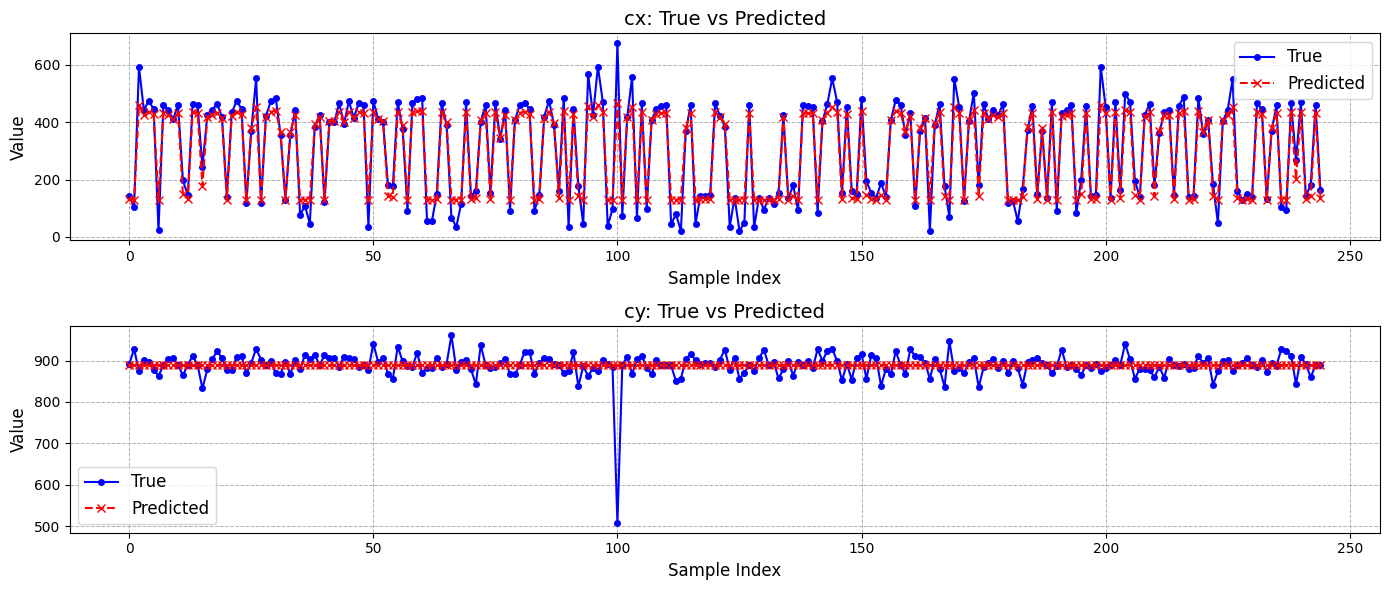

In [17]:
import matplotlib.pyplot as plt
import numpy as np

print("y_test shape:", y_test.shape)
print("predictions shape:", predictions.shape)

# 时间步（样本）索引
samples = np.arange(y_test.shape[0])

# 特征标签
features = ['cx', 'cy']

# 创建图形和子图
fig, axes = plt.subplots(len(features), 1, figsize=(14, 3 * len(features)), tight_layout=True)
axes = axes.flatten()

# 绘制每个特征的真实值和预测值
for i in range(len(features)):
    ax = axes[i]
    ax.plot(samples, y_test[:, i], marker='o', linestyle='-', label='True', color='blue', markersize=4, linewidth=1.5)
    ax.plot(samples, predictions[:, i], marker='x', linestyle='--', label='Predicted', color='red', markersize=6, linewidth=1.5)
    ax.set_title(f'{features[i]}: True vs Predicted', fontsize=14)
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    ax.legend(fontsize=12)

plt.show()


## 5. 评估指标可视化

In [ ]:
import matplotlib.pyplot as plt

# 绘制训练与验证损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练与验证准确度曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. 模型评估与测试

In [ ]:
# 假设有新的测试数据集
test_samples = 10  # 测试样本数
time_steps = 5
num_features = 5
test_data = np.random.rand(test_samples, time_steps, num_features)

# 对测试数据进行标准化：我们使用标准化来将数据缩放到均值为0，标准差为1的范围内
# (num_samples, time_steps, num_features) -> (num_samples * time_steps, num_features)
scaler = StandardScaler()
test_data_reshaped = test_data.reshape(-1, num_features)
test_data_reshaped = scaler.fit_transform(test_data_reshaped)

test_data_reshaped = scaler.transform(test_data_reshaped)
# (num_samples * time_steps, num_features) -> (num_samples, time_steps, num_features)
test_data = test_data_reshaped.reshape(test_samples, time_steps, num_features)

# 使用模型进行预测
predictions = lstm_model.predict(test_data)

# 将预测结果转换为类别标签
predicted_classes = np.argmax(predictions, axis=-1)

# 显示每个测试样本的预测结果
for i in range(test_samples):
    print(f"Sample {i+1} predictions: {predicted_classes[i]}")